In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.028, identitity_weight_decay=0.96)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 1.1772 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5159 | pr auc 0.2466 | elapsed 34.54s
train epoch 01/15 | batch 2001/2000 | loss 0.8565 | val loss 0.4719 | acc 0.8259 | f1 0.3815 | prec 0.7859 | recall 0.2519 | roc auc 0.6919 | pr auc 0.5177 | elapsed 101.23s
train epoch 02/15 | batch 2001/2000 | loss 0.5358 | val loss 0.3592 | acc 0.8611 | f1 0.5736 | prec 0.8292 | recall 0.4384 | roc auc 0.8336 | pr auc 0.7036 | elapsed 93.43s
train epoch 03/15 | batch 2001/2000 | loss 0.3829 | val loss 0.2952 | acc 0.8932 | f1 0.7017 | prec 0.8674 | recall 0.5891 | roc auc 0.8854 | pr auc 0.7985 | elapsed 97.02s
train epoch 04/15 | batch 2001/2000 | loss 0.2797 | val loss 0.2553 | acc 0.9101 | f1 0.7599 | prec 0.8825 | recall 0.6672 | roc auc 0.9111 | pr auc 0.8459 | elapsed 97.88s
train epoch 05/15 | batch 2001/2000 | loss 0.2122 

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [5]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger,identities_weight=0.045, identitity_weight_decay=0.9)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 751/750 | loss 1.2345 | val loss 1.1926 | acc 0.6265 | f1 0.4100 | prec 0.3119 | recall 0.5979 | roc auc 0.6746 | pr auc 0.4919 | elapsed 11.75s
train epoch 01/10 | batch 751/750 | loss 1.0987 | val loss 0.9290 | acc 0.6817 | f1 0.4518 | prec 0.3607 | recall 0.6043 | roc auc 0.7199 | pr auc 0.5423 | elapsed 21.89s
train epoch 02/10 | batch 751/750 | loss 0.8247 | val loss 0.7280 | acc 0.7356 | f1 0.5034 | prec 0.4249 | recall 0.6175 | roc auc 0.7649 | pr auc 0.5970 | elapsed 20.19s
train epoch 03/10 | batch 751/750 | loss 0.6187 | val loss 0.5815 | acc 0.7802 | f1 0.5596 | prec 0.4951 | recall 0.6434 | roc auc 0.8058 | pr auc 0.6545 | elapsed 21.03s
train epoch 04/10 | batch 751/750 | loss 0.4708 | val loss 0.4766 | acc 0.8176 | f1 0.6135 | prec 0.5679 | recall 0.6671 | roc auc 0.8402 | pr auc 0.7093 | elapsed 21.12s
train epoch 05/10 | batch 751/750 | loss 0.3667 | val loss 0.4026 | acc 0.8449 | f1 0.6563 | prec 0.6320 | recall 0.6826 | roc a

In [6]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

In [12]:
np.mean(y_te)

0.217875

local/out/exp/20240722T221546


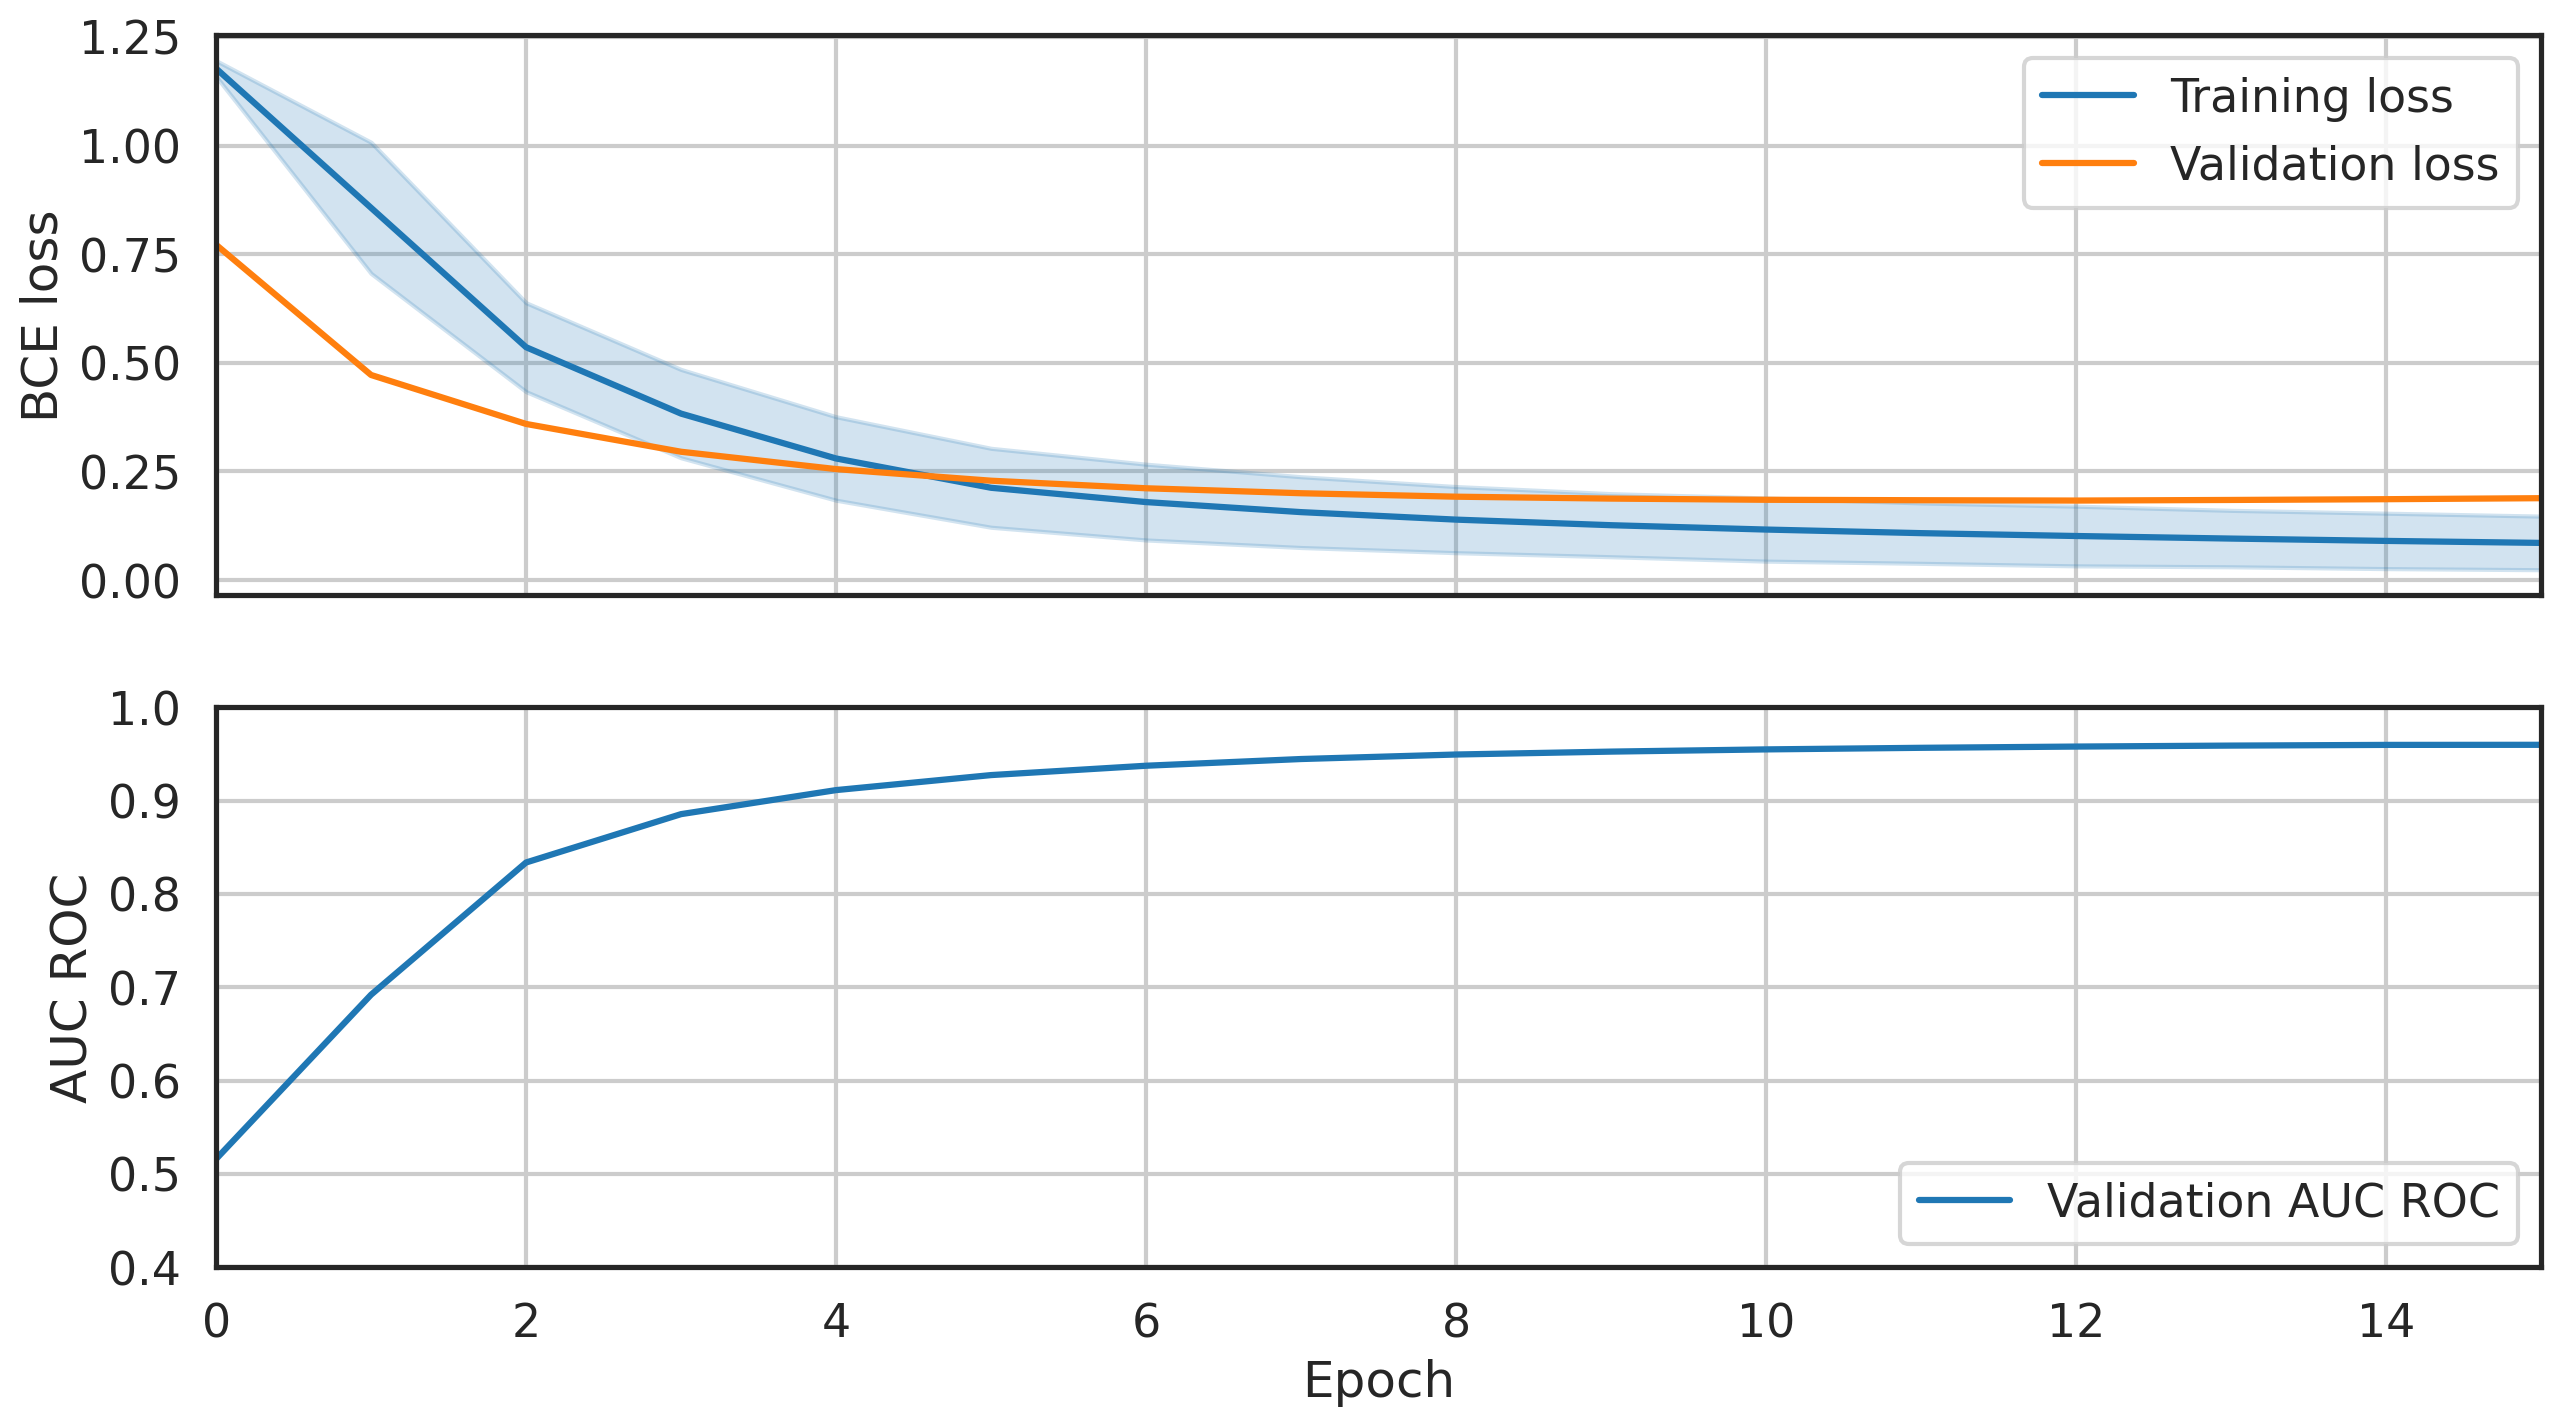

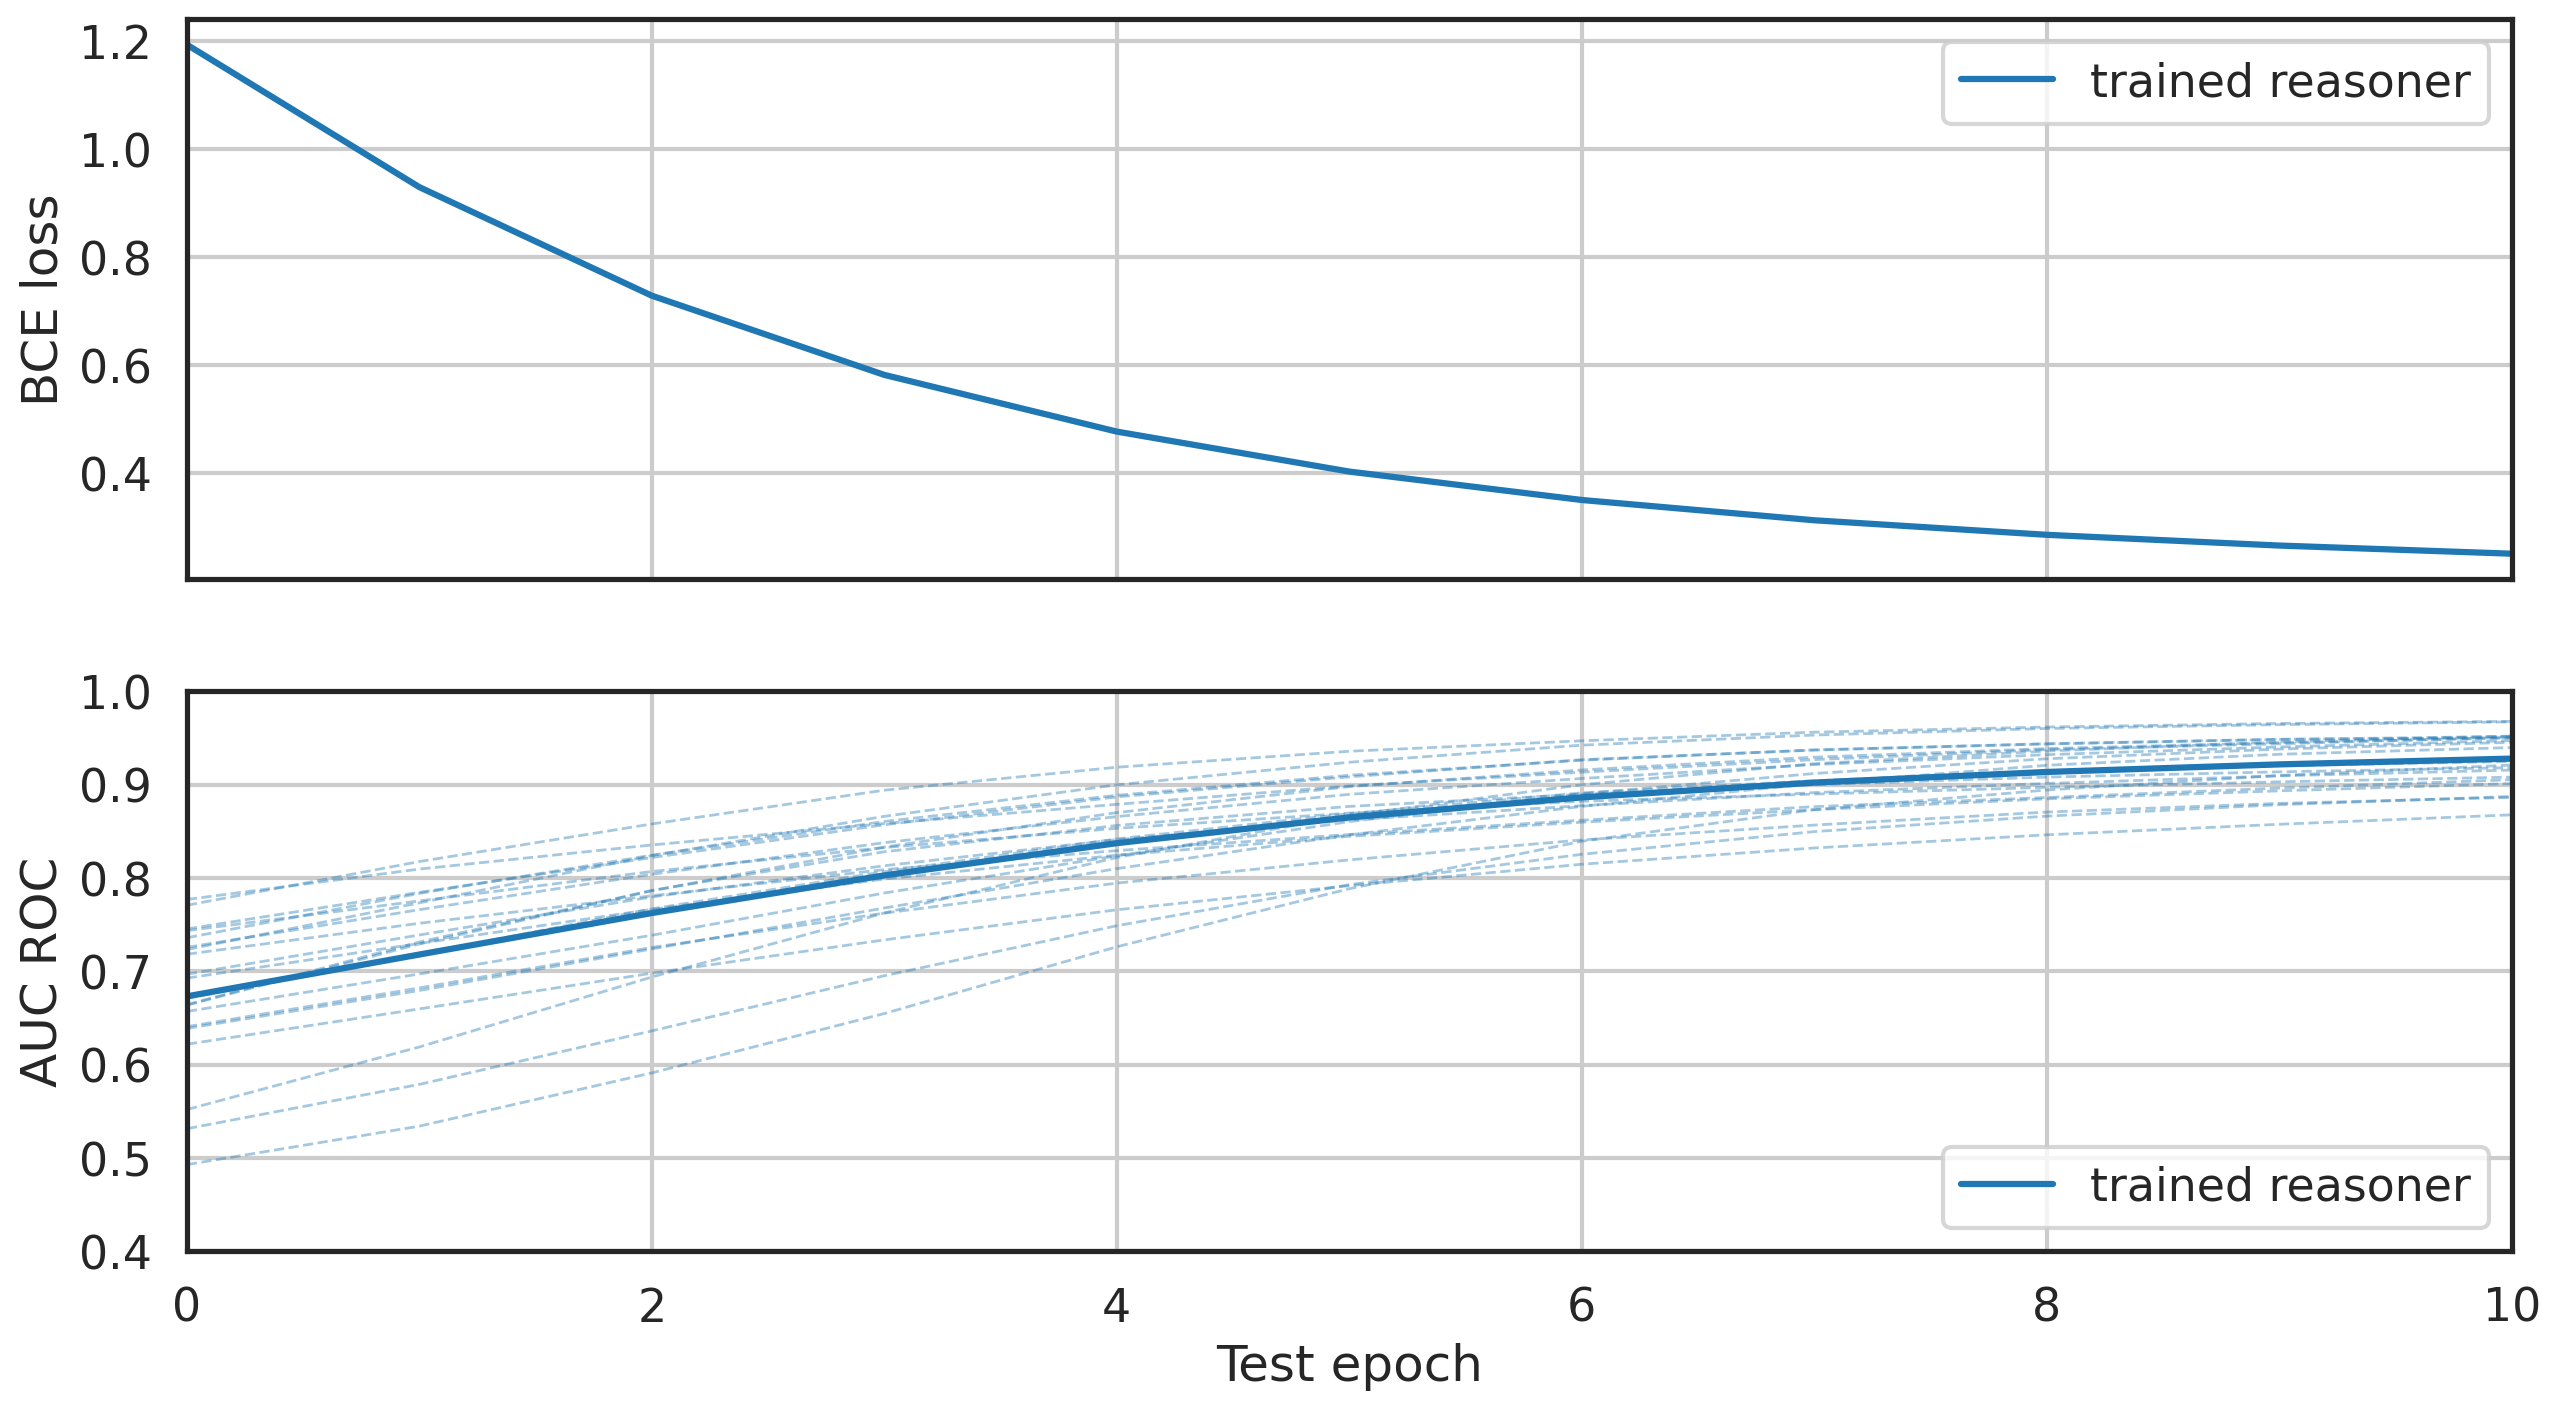

             mean       std     micro
acc      0.910750  0.024389  0.910750
prec     0.811924  0.067417  0.812766
recall   0.763692  0.065936  0.767068
f1       0.785965  0.059300  0.789256
auc_roc  0.922149  0.024819  0.924456
auc_pr   0.866733  0.047013  0.870507


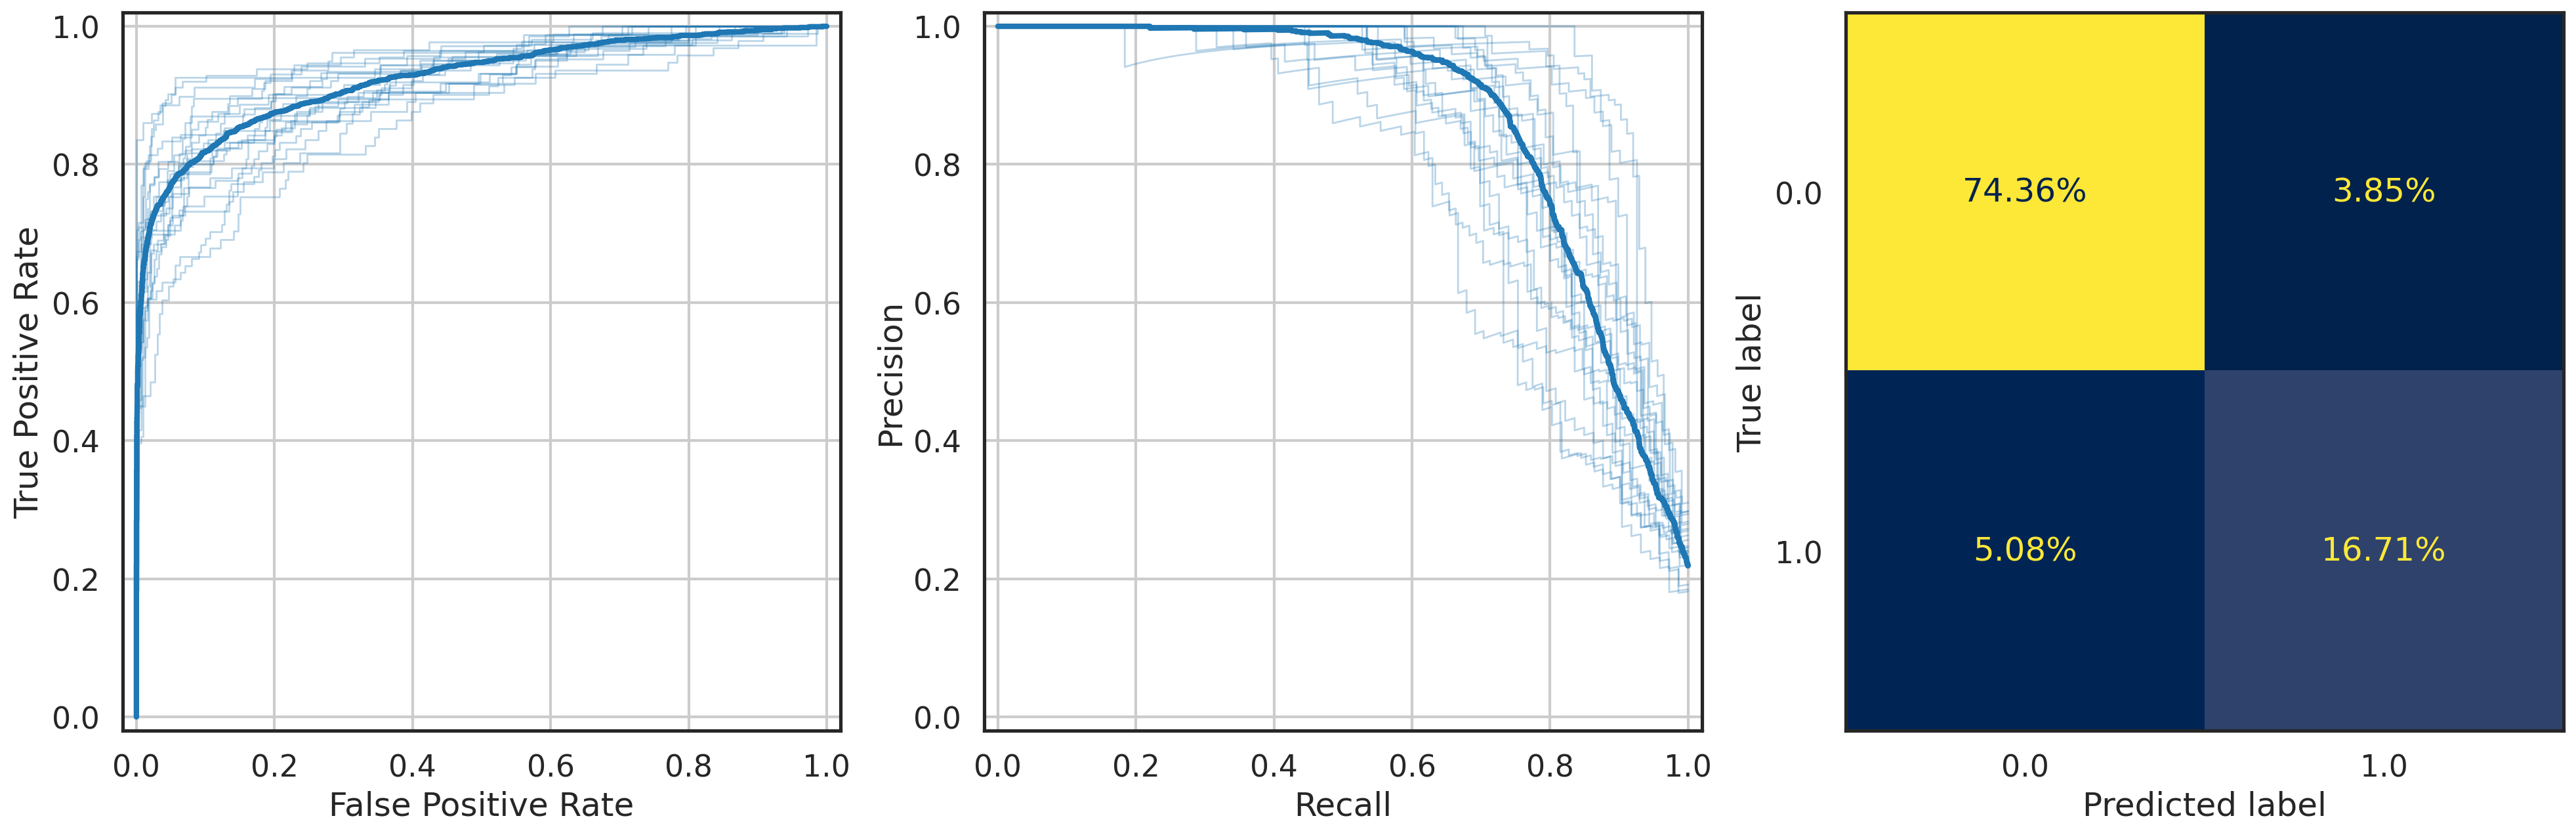

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te, np.array(Y_te_good), idx_te))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [8]:
import random

In [9]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [10]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []
losses_reflexivity_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    reflexivity_subsumption = trained_reasoner.sub_nn(im(input1, input1))
    losses_reflexivity_subsumption.append(1 - T.sigmoid(reflexivity_subsumption).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [11]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Reflexivity of Subsumption", losses_reflexivity_subsumption, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.000009
  Std Dev Loss: 0.000004
  Mean Diff: 0.000021
  Std Dev Diff: 0.000008

Duality of Top and Bottom:
  Mean Loss: 0.000441
  Std Dev Loss: 0.000000
  Mean Diff: 0.001797
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.108147
  Std Dev Loss: 0.026771
  Mean Diff: 0.255810
  Std Dev Diff: 0.071530

Associativity:
  Mean Loss: 0.020947
  Std Dev Loss: 0.007231
  Mean Diff: 0.047373
  Std Dev Diff: 0.016317

Commutativity:
  Mean Loss: 0.024745
  Std Dev Loss: 0.008733
  Mean Diff: 0.057930
  Std Dev Diff: 0.021461

Contradiction:
  Mean Loss: 0.134524
  Std Dev Loss: 0.036458
  Mean Diff: 0.218530
  Std Dev Diff: 0.042730

Identity with Top:
  Mean Loss: 0.065214
  Std Dev Loss: 0.018287
  Mean Diff: 0.157125
  Std Dev Diff: 0.050187

Absorption by Bottom:
  Mean Loss: 0.018171
  Std Dev Loss: 0.008178
  Mean Diff: 0.041914
  Std Dev Diff: 0.016644

Top Concept Subsumption:
  Mean Loss: 0.000985
  Std Dev Loss: 0.000918
  Mean Diff: N/A
  Std De